In [1]:
import numpy as np
import pandas as pd
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\39296\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2070 with Max-Q Design'

In [4]:
dataroot="animals/animals"
classes=os.listdir(dataroot)


In [5]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 224

# Number of channels in the training images. For color images this is 3
nc = 3


# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.9

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

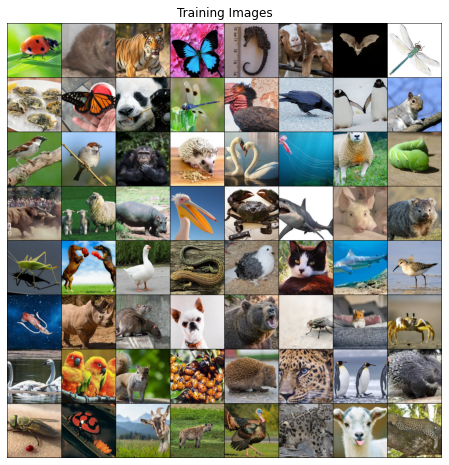

In [6]:
dataset = ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig('training_example.png')

In [8]:
train_ratio=0.7
trainlen=int(len(dataset)*train_ratio)
vallen=len(dataset)-trainlen
train, val=random_split(dataset, [trainlen, vallen])

In [9]:
trainloader = DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=workers, pin_memory=True)

valloader = DataLoader(val, batch_size=batch_size,
                                          shuffle=True, num_workers=workers, pin_memory=True)


# Base line: MLP

In [10]:
#A naive fully connected model mimicking VGG16

class NaiveFCmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten=nn.Flatten()
        self.model=nn.Sequential(
            nn.Linear(3*224*224, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 300),
            nn.ReLU(),
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Linear(150, 90)
        )
    def forward(self, x):
        x = self.flatten(x)
        mod = self.model(x)
       
        
        return mod

In [11]:
naiveM=NaiveFCmodel().to(device)
print(naiveM)

NaiveFCmodel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=150528, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=300, bias=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=150, bias=True)
    (7): ReLU()
    (8): Linear(in_features=150, out_features=90, bias=True)
  )
)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(naiveM.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:

for epoch in range(num_epochs):  # run for epochs 
    correct=0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): #training
        
        inputs, labels = data[0].to(device), data[1].to(device)

        
        optimizer.zero_grad()

        
        outputs = naiveM(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
      
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    accuracy = 100 * correct / len(train)
   

    print("For epoch", epoch+1,"Training Accuracy = {}%".format(accuracy))
    correct = 0
    total = 0
    # validation
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = naiveM(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_acc=100 * correct / total
    print("For epoch",epoch+1, f'Accuracy of the network on the validation images: {val_acc} %')

[1,     1] loss: 0.002
tensor([73, 88, 73, 73, 73, 57, 28, 57, 28, 73, 73, 28, 73, 73, 28, 18, 57, 18,
        28, 88, 73, 28, 73, 88, 18, 18, 73, 73, 44, 88, 73, 73, 73, 18, 73, 28,
        88, 73, 88, 28, 28, 28, 73, 73, 28, 88, 73,  4, 28, 28, 28, 73, 73, 73,
        28, 28, 73, 73, 28, 28, 73, 73, 88, 73], device='cuda:0')
tensor([[ 0.3119,  0.7711,  0.3272,  ..., -0.4703,  1.5895, -0.1283],
        [ 0.2777, -0.2175,  0.6123,  ..., -1.1184,  3.0088, -0.1557],
        [ 0.0450,  0.0786,  0.1795,  ..., -0.6367,  0.6477, -0.0243],
        ...,
        [-0.2307, -0.2402,  0.7952,  ..., -1.0116,  2.3451, -0.0205],
        [ 0.3055,  0.0941,  0.0284,  ..., -0.4066,  1.1523, -0.0681],
        [ 0.0610,  0.1830,  0.0292,  ..., -0.6000,  0.5196, -0.0169]],
       device='cuda:0')
For epoch 1 Training Accuracy = 2.593278646469116%
For epoch 1 Accuracy of the network on the validation images: 2.1591610117211597 %
[2,     1] loss: 0.002
tensor([49, 78,  5, 49, 49, 78, 19, 67, 89, 84, 67, 49, 

For epoch 9 Accuracy of the network on the validation images: 11.227637260950031 %
[10,     1] loss: 0.001
tensor([26, 62, 69, 58, 84,  4, 63, 49, 78, 49, 80, 27, 42, 54,  9, 22, 10, 81,
         3, 81, 49, 54,  8, 59, 25, 17,  8,  6, 75, 73, 47, 70, 85,  4, 26, 43,
         9, 22, 85, 18, 10, 11, 47, 75, 62, 18, 27, 25, 63, 47,  6, 70, 70, 62,
        85, 26, 22, 45, 40, 49, 80, 77,  3, 87], device='cuda:0')
tensor([[-1.2917, -1.4721, -1.0230,  ..., -0.8728, -0.9647,  0.7789],
        [-0.7526, -4.6180, -3.8761,  ..., -4.3130, -2.8573,  0.2522],
        [-1.5763, -1.7977, -2.4413,  ..., -2.9953, -2.0074, -0.6651],
        ...,
        [-0.3593, -1.4001, -0.9213,  ..., -0.5274,  0.0482,  0.6732],
        [-3.7883,  2.9758,  1.1134,  ..., -1.6615, -0.4451,  1.4951],
        [-5.1339,  3.0988, -0.1692,  ...,  3.7323,  0.5460, -4.0135]],
       device='cuda:0')
For epoch 10 Training Accuracy = 29.34638786315918%
For epoch 10 Accuracy of the network on the validation images: 12.33806292412

Looks like fully connected linear model is terrible for training image data set

In [42]:
PATH = './naive.pth'
torch.save(naiveM.state_dict(), PATH)